# Extracting Images from Adidas PDF 
*Version*: matches manuf_models with item_id **and** sport_id <br/>

**Libraries used:**
- **pdfplumber**: opens pdfs and allows them to be parsed page by page
- **re**: finds patterns in text to know where to find specific data (e.g. dates, model numbers, etc.)
- **glob**: allows for iterating through files ending in .pdf
- **csv**: used here for reading matching manuf_model to item_ids
- **fitz**: extracting images
- **os**: for getting current directory and creating a new folder containing images

In [1]:
import pdfplumber
import re
import glob
import csv
import fitz
import os

In [2]:
manuf_model_re = re.compile(r'(\w+)\D+\d+\D+\d+\D+\d+\D+\d+')

**Extracting model numbers**

The function below goes through the PDF and returns a list of all model numbers found. 

*Note*: Please make sure your PDF files are in the folder called *put_pdfs_here*

In [3]:
def extract_model_nums():
    """
    Returns: a list of all model numbers in an Adidas PDF
    Assumptions: your PDF's are in the folder called "put_pdfs_here"
    
    """
    model_nums = []
    check_model_num = False

    for file in glob.iglob("put_pdfs_here/*pdf"):
        with pdfplumber.open(file) as pdf:
            pages = pdf.pages
            for page in pdf.pages:
                text = page.extract_text()
                for line in text.split("\n"):

                    if line.startswith('Style') or line.startswith('Qty'):
                        check_model_num = True

                    elif check_model_num:
                        model_num = manuf_model_re.search(line)
                        if model_num:
                            model_nums.append(model_num.group(1))
                        check_model_num = False
                        
    return model_nums      

**Matching item id**

The function below takes calls extract_model_nums() to get the list of model numbers and matches them to the corresponding item_ids in the CSV file that contains all items for the org. 

*Note*: Please make sure the CSV file is named *all_items.csv* and contains the appropriate columns (refer to image below)
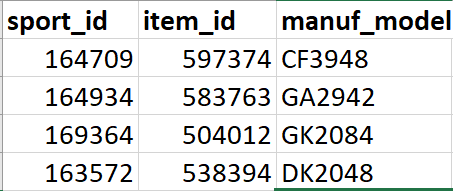

In [18]:
def get_item_ids(sport_id):
    """
    Returns: a list of all item_ids corresponding to the model numbers, and a list of item_ids
    
    """
    item_ids = []
    model_nums = extract_model_nums()
    
    with open('all_items.csv', 'r', encoding='utf-8-sig') as file:
        reader = csv.reader(file)

        for line in reader:
            for model_num in model_nums:
                if line[0] == sport_id and line[2] == model_num:
                    print("yes")
                    item_ids.append(line[1])
                 
    return item_ids
    

**Image extraction process**

The code below extracts all images from the PDF, names them accordingly by the item_ids, and places them in a folder. It also creates a csv file containing the queries you will need.

In [19]:
sport_id = input("Enter the sport_id: ")
# The actual image extraction
image_num = -1
for file in glob.iglob("put_pdfs_here/*pdf"):
    doc = fitz.open(file)
    item_ids = get_item_ids(sport_id)
    # new directories that will hold images
    all_path = os.path.join(os.getcwd(), "All Files")
    sport_path = os.path.join(os.getcwd(), sport_id)
    if not os.path.exists('All Files'):
        os.mkdir(all_path)
    os.mkdir(sport_path)
    
    for i in range(len(doc)):
        for img in doc.getPageImageList(i):
            
            # this step is needed because the first image is always the Adidas logo, which we don't want
            if image_num == -1:
                image_num += 1
                continue
                
            xref = img[0]
            pix = fitz.Pixmap(doc, xref)
            
            for j in range(len(item_ids[image_num])):
                pix.writePNG(f"{all_path}/I{item_ids[image_num]}.jpg")
                pix.writePNG(f"{all_path}/I{item_ids[image_num]}Thumb.jpg")
                pix.writePNG(f"{sport_path}/I{item_ids[image_num]}.jpg")
                pix.writePNG(f"{sport_path}/I{item_ids[image_num]}Thumb.jpg")
            pix = None
            
            image_num += 1
            
# Outputting item_ids into a csv to generate queries
with open('queries.csv', 'w') as file:
    writer = csv.writer(file)
    for i in range(len(item_ids)):
        writer.writerow([f"insert into item_avatar(item_id, avatar_link, avatar_thumbnail_link, last_modified, last_modified_by) select i.item_id, 'https://acsequip.acsathletics.com/Images/ItemAvatar/I' + cast(i.item_id as varchar) + '.jpg', 'https://acsequip.acsathletics.com/Images/ItemAvatar/I' + cast(i.item_id as varchar) + 'Thumb.jpg', dateadd(hh,o.time_diff,getDate()), e.employee_id from item i inner join org o on i.org_id = o.org_id inner join employee e on e.org_id = o.org_id left join ITEM_AVATAR ia on ia.item_id = i.item_id where i.item_id = {item_ids[i]} and ia.item_id is null and e.logon_id = 'acs' + cast(o.org_id as varchar)"])


Enter the sport_id: 3


FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'C:\\Users\\16479\\extract_pdf\\Adidas images\\3'